<a href="https://colab.research.google.com/github/victorviro/Deep_learning_python/blob/master/Keras_Functional_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## The Functional API

[Here](https://github.com/victorviro/Deep_learning_python/blob/master/Introduction_artificial_neural_networks_keras.ipynb) we used the Sequential API of Keras to build a MLP classifier. Although sequential models are extremely common, it is sometimes useful to build neural networks with more complex topologies, or with multiple inputs or outputs. For this purpose, Keras offers the Functional API.


One example of a non-sequential neural network is a *Wide & Deep* neural network. This neural network architecture was introduced in a [paper](https://arxiv.org/abs/1606.07792) by Heng-Tze Cheng in 2016. It connects all or part of the inputs directly to the output layer, as shown in
Figure 10-13.

![texto alternativo](https://i.ibb.co/pPrpHsz/WDNN.png)

This architecture makes it possible for the neural network to learn both
deep patterns (using the deep path) and simple rules (through the short path). In contrast, a regular MLP forces all the data to flow through the full stack of layers, thus simple patterns in the data may end up being distorted by this sequence of transformations.

Let’s build such a neural network to tackle the [California housing problem](https://scikit-learn.org/stable/datasets/index.html#california-housing-dataset):

In [1]:
# Let's load, split and scale the California housing dataset

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [2]:
# build the neural network
import keras

input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input_)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_, hidden2])
output = keras.layers.Dense(1)(concat)
model = keras.models.Model(inputs=[input_], outputs=[output])

Let’s go through each line of this code:


- First, we need to create an `Input` object. This is needed because we may have
multiple inputs, as we will see later.

- Next, we create a `Dense` layer with 30 neurons and using the ReLU activation
function. As soon as it is created, notice that we call it like a function, passing it the input. This is why this is called the Functional API. Note that we are just telling Keras how it should connect the layers together, no actual data is being processed yet.

- We then create a second hidden layer, and again we use it as a function. Note
however that we pass it the output of the first hidden layer.

- Next, we create a `Concatenate()` layer, and once again we immediately use it like a function, to concatenate the input and the output of the second hidden layer.

- Then we create the output layer, with a single neuron and no activation function, and we call it like a function, passing it the result of the concatenation.

- Lastly, we create a Keras `Model`, specifying which inputs and outputs to use. Remember that in the Sequential API we instantiate the model object when calling `model = Sequential()` (and then add layers and constraints). In the Functional API, we create layers and then instantiate our model by calling `model = Model()` with our desired input and output layer(s) as we did.




In [3]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 30)           270         input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 30)           930         dense[0][0]                      
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 38)           0           input_1[0][0]                    
                                                                 dense_1[0][0]         

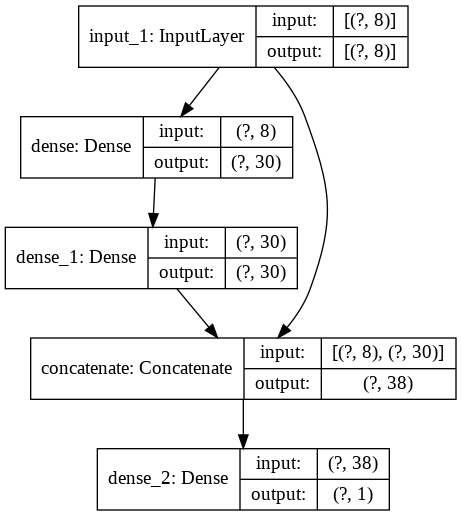

In [4]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

We compile the model, train it, evaluate it and use it to make predictions.

In [5]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 2.0039 - val_loss: 1.0261
Epoch 2/20
363/363 [==============================] - 1s 1ms/step - loss: 0.8052 - val_loss: 0.7651
Epoch 3/20
363/363 [==============================] - 1s 1ms/step - loss: 0.7318 - val_loss: 0.6636
Epoch 4/20
363/363 [==============================] - 1s 1ms/step - loss: 0.6788 - val_loss: 0.6146
Epoch 5/20
363/363 [==============================] - 1s 1ms/step - loss: 0.6381 - val_loss: 0.5794
Epoch 6/20
363/363 [==============================] - 0s 1ms/step - loss: 0.6046 - val_loss: 0.5507
Epoch 7/20
363/363 [==============================] - 1s 1ms/step - loss: 0.5767 - val_loss: 0.5219
Epoch 8/20
363/363 [==============================] - 1s 1ms/step - loss: 0.5523 - val_loss: 0.5000
Epoch 9/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5315 - val_loss: 0.5010
Epoch 10/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5129 - val_loss: 0.4709

But what if we want to send a subset of the features through the wide path, and a different subset (possibly overlapping) through the deep path (see Figure 10-14)? 

![texto alternativo](https://i.ibb.co/KzbDTjB/multiple-inputs.png)

In this case, one solution is to use multiple inputs. For example, suppose we want to send 5 features through the deep path (features 0 to 4), and 6 features through the wide path (features 2 to 7):

In [6]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="output")(concat)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

The code is self-explanatory. Note that we specified `inputs=[input_A, input_B]` when creating the model.

In [7]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
deep_input (InputLayer)         [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 30)           210         deep_input[0][0]                 
__________________________________________________________________________________________________
wide_input (InputLayer)         [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 30)           930         dense_3[0][0]                    
_______________________________________________________________________________________

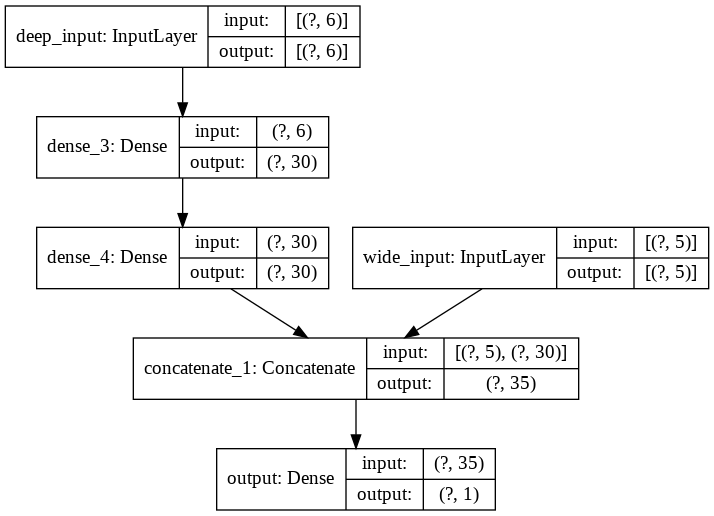

In [8]:
plot_model(model, to_file='model.png', show_shapes=True)

Now we can compile the model as usual, but when we call
the `fit()` method, instead of passing a single input matrix `X_train` , we must pass a pair of matrices `(X_train_A, X_train_B)` : one per input. The same is true for `X_valid`, and also for `X_test` and `X_new` when we call `evaluate()` or `predict()`:

In [9]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

history = model.fit([X_train_A, X_train_B], y_train, epochs=20,
                    validation_data=([X_valid_A, X_valid_B], y_valid))

mse_test = model.evaluate([X_test_A, X_test_B], y_test)
y_pred = model.predict([X_new_A, X_new_B])

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 2.2604 - val_loss: 4.8429
Epoch 2/20
363/363 [==============================] - 0s 1ms/step - loss: 0.8112 - val_loss: 0.9116
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: 0.6780 - val_loss: 0.6097
Epoch 4/20
363/363 [==============================] - 0s 1ms/step - loss: 0.6253 - val_loss: 0.5753
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5899 - val_loss: 0.6182
Epoch 6/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5622 - val_loss: 0.5458
Epoch 7/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5379 - val_loss: 0.5512
Epoch 8/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5179 - val_loss: 0.5571
Epoch 9/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5019 - val_loss: 0.5323
Epoch 10/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4890 - val_loss: 0.4966

There are also many use cases in which we may want to have multiple outputs:


- The task may demand it, for example we may want to locate and classify the main object in a picture. This is both a regression task (finding the coordinates of the object’s center, as well as its width and height) and a classification task.

- Similarly, we may have multiple independent tasks to perform based on the same data. Sure, we could train one neural network per task, but in many cases we will get better results on all tasks by training a single neural network with one output per task. This is because the neural network can learn features in the data that are useful across tasks.

- Another use case is as a regularization technique (i.e., a training constraint whose objective is to reduce overfitting and thus improve the model’s ability to generalize). For example, we may want to add some auxiliary outputs in a neural network architecture (see Figure 10-15) to ensure that the underlying part of the network learns something useful on its own, without relying on the rest of the network.

![texto alternativo](https://i.ibb.co/pLKmRgw/multiple-outputs.png)

Adding extra outputs is quite easy: we just connect them to the appropriate layers and add them to our model’s list of outputs. For example, the following code builds the network represented in Figure 10-15:

In [10]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="main_output")(concat)
aux_output = keras.layers.Dense(1, name="aux_output")(hidden2)
model = keras.models.Model(inputs=[input_A, input_B],
                           outputs=[output, aux_output])

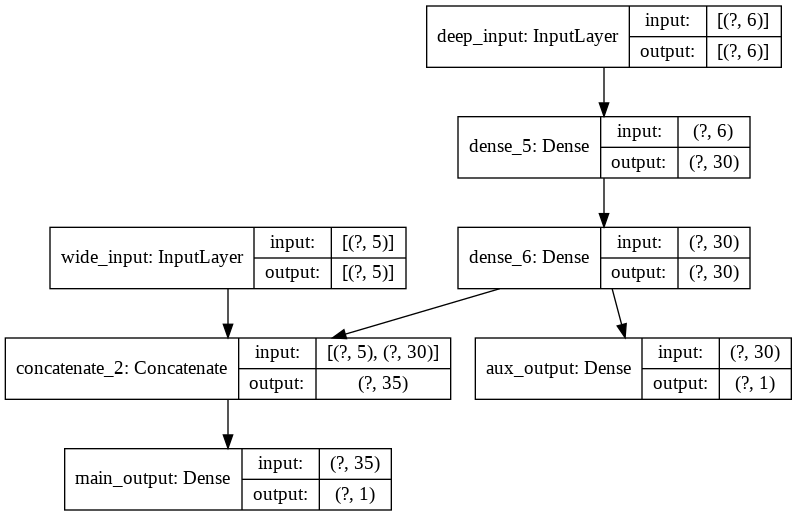

In [11]:
plot_model(model, to_file='model.png', show_shapes=True)

Each output will need its own loss function, so when we compile the model we
should pass a list of losses (if we pass a single loss, Keras will assume that the same loss must be used for all outputs). By default, Keras will compute all these losses and simply add them up to get the final loss used for training. However, we care much more about the main output than about the auxiliary output (as it is just used for regularization), so we want to give the main output’s loss a much greater weight. Fortunately, it is possible to set all the loss weights when compiling the model:

In [12]:
model.compile(loss=["mse", "mse"], loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(lr=1e-3))

Now when we train the model, we need to provide some labels for each output. In
this example, the main output and the auxiliary output should try to predict the same thing, so they should use the same labels. So instead of passing `y_train` , we just need to pass `[y_train, y_train]` (and the same goes for `y_valid` and `y_test`):

In [13]:
history = model.fit([X_train_A, X_train_B], [y_train, y_train], epochs=20,
                    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]))

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 2.5537 - main_output_loss: 2.1998 - aux_output_loss: 5.7393 - val_loss: 1.7816 - val_main_output_loss: 0.9760 - val_aux_output_loss: 9.0317
Epoch 2/20
363/363 [==============================] - 1s 1ms/step - loss: 1.0943 - main_output_loss: 0.7509 - aux_output_loss: 4.1846 - val_loss: 1.1348 - val_main_output_loss: 0.6807 - val_aux_output_loss: 5.2222
Epoch 3/20
363/363 [==============================] - 1s 1ms/step - loss: 0.8928 - main_output_loss: 0.6599 - aux_output_loss: 2.9888 - val_loss: 0.8805 - val_main_output_loss: 0.6356 - val_aux_output_loss: 3.0849
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.7745 - main_output_loss: 0.6121 - aux_output_loss: 2.2361 - val_loss: 0.7417 - val_main_output_loss: 0.5961 - val_aux_output_loss: 2.0526
Epoch 5/20
363/363 [==============================] - 1s 1ms/step - loss: 0.6963 - main_output_loss: 0.5754 - aux_output_loss: 1.7846 - val_loss

When we evaluate the model, Keras will return the total loss, as well as all the individual losses:

In [14]:
total_loss, main_loss, aux_loss = model.evaluate(
    [X_test_A, X_test_B], [y_test, y_test])


162/162 [==============================] - 0s 985us/step - loss: 0.4794 - main_output_loss: 0.4234 - aux_output_loss: 0.9838


Similarly, the `predict()` method will return predictions for each output:

In [15]:
y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])

As we can see, we can build any sort of architecture we want quite easily with the Functional API. Let’s look at one last way we can build Keras models.

## The Subclassing API

Both the Sequential API and the Functional API are declarative: we start by declaring which layers we want to use and how they should be connected, and only then can we start feeding the model some data for training or inference. This has many advantages: the model can easily be saved, cloned, shared, its structure can be displayed and analyzed, the framework can infer shapes and check types, so errors can be caught early (i.e., before any data ever goes through the model). It’s also fairly easy to debug, since the whole model is just a static graph of layers. But the flip side is just that: it’s static. Some models involve loops, varying shapes, conditional branching, and other dynamic behaviors. For such cases, or simply if we prefer a more imperative programming style, the Subclassing API is for us.

Simply subclass the `Model` class, create the layers we need in the constructor, and use them to perform the computations we want in the `call()` method. For example, creating an instance of the following `WideAndDeepModel` class gives us an equivalent model to the one we just built with the Functional API. We can then compile it, evaluate it and use it to make predictions, exactly like we just did.



In [16]:
class WideAndDeepModel(keras.models.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)
        
    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output

model = WideAndDeepModel(30, activation="relu")

In [19]:
model.compile(loss="mse", loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit([X_train_A, X_train_B], [y_train, y_train], epochs=10,
                    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]))
total_loss, main_loss, aux_loss = model.evaluate([X_test_A, X_test_B], [y_test, y_test])
y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])

Epoch 1/10
363/363 [==============================] - 1s 2ms/step - loss: 2.9078 - output_1_loss: 2.6175 - output_2_loss: 5.5204 - val_loss: 7.6252 - val_output_1_loss: 7.9339 - val_output_2_loss: 4.8474
Epoch 2/10
363/363 [==============================] - 1s 1ms/step - loss: 1.1876 - output_1_loss: 0.9069 - output_2_loss: 3.7138 - val_loss: 1.2311 - val_output_1_loss: 1.0472 - val_output_2_loss: 2.8860
Epoch 3/10
363/363 [==============================] - 1s 1ms/step - loss: 0.8768 - output_1_loss: 0.6970 - output_2_loss: 2.4956 - val_loss: 0.7860 - val_output_1_loss: 0.6276 - val_output_2_loss: 2.2116
Epoch 4/10
363/363 [==============================] - 1s 1ms/step - loss: 0.7536 - output_1_loss: 0.6303 - output_2_loss: 1.8635 - val_loss: 0.7521 - val_output_1_loss: 0.6011 - val_output_2_loss: 2.1116
Epoch 5/10
363/363 [==============================] - 1s 1ms/step - loss: 0.6885 - output_1_loss: 0.5916 - output_2_loss: 1.5613 - val_loss: 0.7069 - val_output_1_loss: 0.5512 - val_ou

In [20]:
model.summary()

Model: "wide_and_deep_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              multiple                  210       
_________________________________________________________________
dense_8 (Dense)              multiple                  930       
_________________________________________________________________
dense_9 (Dense)              multiple                  36        
_________________________________________________________________
dense_10 (Dense)             multiple                  31        
Total params: 1,207
Trainable params: 1,207
Non-trainable params: 0
_________________________________________________________________


This example looks very much like the Functional API, except we do not need to create the inputs, we just use the input argument to the `call()` method, and we separate the creation of the layers in the constructor from their usage in the `call()` method. However, the big difference is that we can do pretty much anything we want in the `call()` method: for loops, if statements, low-level TensorFlow operations, our imagination is the limit. This makes it a great API for researchers experimenting with new ideas.

However, this extra flexibility comes at a cost: our model’s architecture is hidden within the `call()` method, so Keras cannot easily inspect it, it cannot save or clone it, and when we call the `summary()` method, we only get a list of layers, without any information on how they are connected to each other. Moreover, Keras cannot check types and shapes ahead of time, and it is easier to make mistakes. So unless we really need that extra flexibility, we should probably stick to the Sequential API or the Functional API.